# Using KGFE for feature explanation

Basically, given a list of genes/proteins/metabolites that are mapped onto SPOKE, we want to identify nodes on the graph that are in some way "similar" to the input nodes.

In [1]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
import kgfe

## 1. Load proteins from Arivale prediction experiments

We are going to get the top most predictive proteins/metabolites for next-time-point HbA1C.

In [2]:
prots_data = pd.read_csv('prots_lassocv_hba1c_top_weights.csv', index_col=0)

In [3]:
prots_data.head()

,weight,gene_name,uniprot
CVD2_P09341,0.004217,CXCL1,P09341
INF_Q5T4W7,0.004247,ARTN,Q5T4W7
INF_Q13007,0.004683,IL24,Q13007
CVD3_Q9H2A7,0.005046,CXCL16,Q9H2A7
CVD2_P51161,0.005645,FABP6,P51161


In [4]:
mets_data = pd.read_csv('mets_lassocv_hba1c_top_weights.csv', index_col=0)

In [5]:
mets_data

,weight,name,KEGG,PUBCHEM,CHEMBL
100005372,-0.015027,1-(1-enyl-oleoyl)-GPE (P-18:1)*,NaN,NaN,NaN
1023,-0.013812,sarcosine,C00213,1088.0,CHEMBL304383
100020241,-0.013133,gamma-glutamylcitrulline*,NaN,NaN,NaN
100008998,-0.012156,gamma-tocopherol/beta-tocopherol,NaN,NaN,NaN
100000827,-0.011766,1-palmitoylglycerol (16:0),NaN,14900.0,CHEMBL1078140
100000263,-0.010207,imidazole lactate,C05568,793.0,NaN
100002953,-0.010121,16-hydroxypalmitate,C18218,10466.0,CHEMBL4281719
461,-0.010002,phosphate,C00009,1061.0,NaN
100009027,-0.007548,"sphingomyelin (d18:0/18:0, d19:0/17:0)*",NaN,NaN,NaN
100001620,-0.007026,glycerophosphoethanolamine,C01233,123874.0,NaN


## 2. Load SPOKE

In [6]:
spoke_graph = kgfe.spoke_loader.load_spoke_networkx('../../graph_utils/spoke_2021.jsonl.gz', directed=True,
                                                    verbose=False)

`kgfe.spoke_loader.load_spoke_networkx` is a function to load the SPOKE graph in as a Networkx Graph or DiGraph.
`spoke_2021.jsonl.gz` is a file exported by Neo4J. We might want to use both directed and undirected versions of this graph, so we're loading it first as a directed graph (networkx.DiGraph) into a variable named `spoke_graph`.

In [7]:
# undirected version of spoke graph
spoke_graph_ud = nx.Graph(spoke_graph)

This creates an undirected graph (networkx.Graph) from the original graph, named `spoke_graph_ud`.

In [8]:
spoke_ids = list(sorted(spoke_graph_ud.nodes.keys()))

Okay, `spoke_ids` is a sorted list of all SPOKE node IDs. These IDs don't have anything to do with intrinsic node properties, but they're generated by Neo4J as unique node identifiers.

In [9]:
names_to_ids = kgfe.graph_info.get_names_to_ids(spoke_graph_ud)
uniprot_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud, 'Protein', source='UNIPROT')
uniprot_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud, 'Protein', source='UNIPROT')

### Map proteins to SPOKE nodes

In [10]:
gene_spoke_ids = [names_to_ids[g] for g in prots_data.gene_name]

## 3. Run topic PageRank

In [11]:
pr_results_personalized, top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud,gene_spoke_ids, )

In [12]:
pr_results_base = nx.pagerank(spoke_graph_ud)

pr_results_ratio is the ratio between the topic pagerank results and the baseline pagerank results - this indicates the increase in likelihood that the nodes will be visited in a personalized random walk, and is an attempt to control for nodes that are important globally.

In [13]:
pr_results_ratio = {x: pr_results_personalized[x]/pr_results_base[x] for x in spoke_ids}

### Analyzing PageRank results

In [14]:
from collections import Counter

In [15]:
pr_results_personalized = Counter(pr_results_personalized)
pr_results_base = Counter(pr_results_base)
pr_results_ratio = Counter(pr_results_ratio)

In [25]:
top_nodes = []
prot_spoke_ids_set = set(gene_spoke_ids)
for node_id, score in pr_results_personalized.most_common():
    if node_id in prot_spoke_ids_set:
        continue
    node = spoke_graph_ud.nodes[node_id].copy()
    node['score'] = score
    top_nodes.append(node)

In [16]:
top_nodes_ratio = []
prot_spoke_ids_set = set(gene_spoke_ids)
for node_id, score in pr_results_ratio.most_common():
    if node_id in prot_spoke_ids_set:
        continue
    node = spoke_graph_ud.nodes[node_id].copy()
    node['score'] = score
    top_nodes_ratio.append(node)

In [26]:
top_nodes[:50]

[{'name': 'Class I Histocompatibility antigen, domains alpha 1 and 2',
  'category': 'ProteinDomain',
  'identifier': 'PF00129',
  'source': 'Pfam',
  'score': 0.014048415029072156},
 {'name': 'Immunoglobulin V-set domain',
  'category': 'ProteinDomain',
  'identifier': 'PF07686',
  'source': 'Pfam',
  'score': 0.009605504254324129},
 {'name': 'Immunoglobulin C1-set domain',
  'category': 'ProteinDomain',
  'identifier': 'PF07654',
  'source': 'Pfam',
  'score': 0.00732708296283871},
 {'name': 'Class II histocompatibility antigen, beta domain',
  'category': 'ProteinDomain',
  'identifier': 'PF00969',
  'source': 'Pfam',
  'score': 0.006993983524612801},
 {'name': 'MHC_I C-terminus',
  'category': 'ProteinDomain',
  'identifier': 'PF06623',
  'source': 'Pfam',
  'score': 0.0023180940584715073},
 {'name': 'KCNH2_HUMAN',
  'category': 'Protein',
  'identifier': 'Q12809',
  'source': 'UniProt',
  'score': 0.0015403429293206576},
 {'name': 'A0A090N8Q0_HUMAN',
  'category': 'Protein',
  'id

In [28]:
top_proteins = [x for x in top_nodes if x['category'] == 'Protein']
top_genes = [x for x in top_nodes if x['category'] == 'Gene']

In [19]:
top_nodes_ratio[:50]

[{'name': 'extracellular matrix protein binding',
  'category': 'MolecularFunction',
  'identifier': 'GO:1990430',
  'source': 'Gene Ontology',
  'score': 161.28200163725518},
 {'name': 'glial cell-derived neurotrophic factor receptor binding',
  'category': 'MolecularFunction',
  'identifier': 'GO:0030116',
  'source': 'Gene Ontology',
  'score': 149.29181496014365},
 {'name': 'chemokine activity',
  'category': 'MolecularFunction',
  'identifier': 'GO:0008009',
  'source': 'Gene Ontology',
  'score': 123.31260448898213},
 {'name': 'T cell chemotaxis',
  'category': 'BiologicalProcess',
  'identifier': 'GO:0010818',
  'source': 'Gene Ontology',
  'score': 118.10514462012762},
 {'name': 'lymphocyte chemotaxis',
  'category': 'BiologicalProcess',
  'identifier': 'GO:0048247',
  'source': 'Gene Ontology',
  'score': 109.88792917742424},
 {'name': 'CCR1 chemokine receptor binding',
  'category': 'MolecularFunction',
  'identifier': 'GO:0031726',
  'source': 'Gene Ontology',
  'score': 109

In [38]:
top_processes = [x for x in top_nodes if x['category'] == 'BiologicalProcess']

### Plot PageRank results

In [20]:
import matplotlib.pyplot as plt

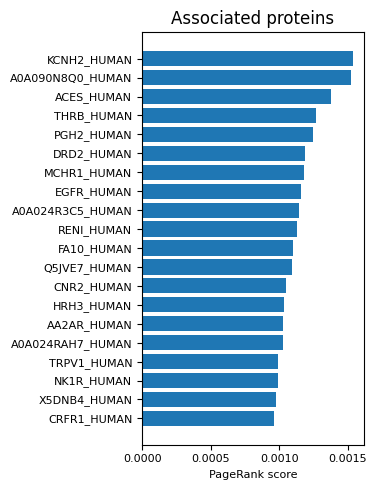

In [29]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in top_proteins[:20][::-1]], [x['score'] for x in top_proteins[:20][::-1]], )
plt.title('Associated proteins')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

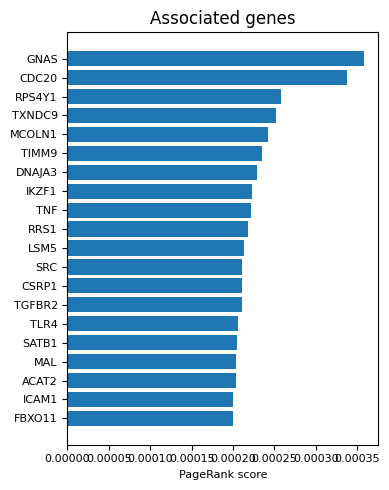

In [30]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in top_genes[:20][::-1]], [x['score'] for x in top_genes[:20][::-1]], )
plt.title('Associated genes')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

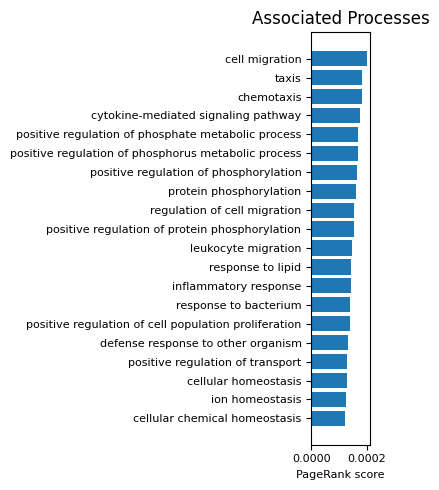

In [39]:
fig, ax = plt.subplots(figsize=(4, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['name'] for x in top_processes[:20][::-1]], [x['score'] for x in top_processes[:20][::-1]], )
plt.title('Associated Processes')
ax.set_xlabel('PageRank score', fontsize=8)
plt.tight_layout()

## 4. Construct Steiner trees for the gene query set

In order to do Steiner trees, it's necessary to get a connected graph. We'll try to build a connected graph that includes all the proteins in the query set.

In [31]:
protein_paths = nx.single_source_dijkstra(spoke_graph_ud, gene_spoke_ids[0])
protein_subgraph = nx.subgraph(spoke_graph, protein_paths[0].keys())

In [32]:
protein_subgraph_ud = nx.Graph(protein_subgraph)

In [33]:
top_protein_st = nx.approximation.steiner_tree(protein_subgraph_ud, gene_spoke_ids, method='mehlhorn')

This is an approximate Steiner tree containing all of the input proteins.

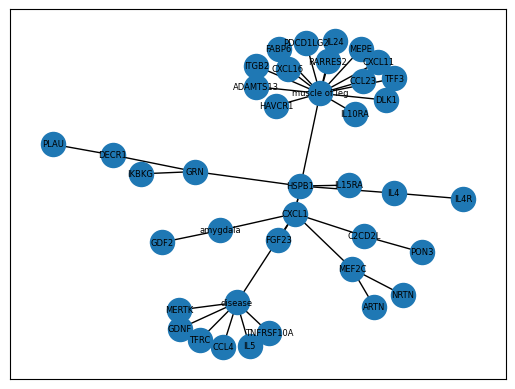

In [34]:
nx.draw_networkx(top_protein_st, pos=nx.spring_layout(top_protein_st),
                 labels={n: top_protein_st.nodes[n]['name'] for n in top_protein_st.nodes()}, font_size=6)

In [35]:
is_in_set = {n: n in gene_spoke_ids for n in top_protein_st.nodes}
nx.set_node_attributes(top_protein_st, is_in_set, 'in_query')

In [36]:
top_protein_subgraph = nx.subgraph(protein_subgraph, top_protein_st)

This is a directed subgraph containing the above Steiner tree (approximately the smallest subgraph containing all of the input proteins).

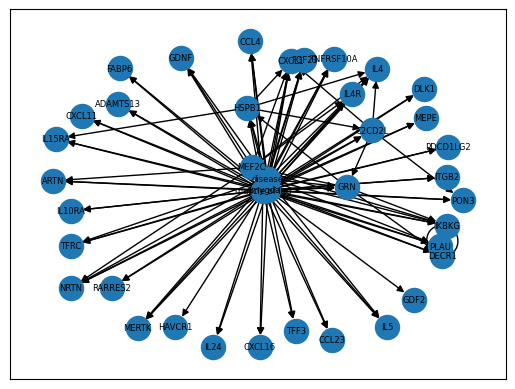

In [37]:
nx.draw_networkx(top_protein_subgraph, pos=nx.spring_layout(top_protein_subgraph),
                 labels={n: top_protein_subgraph.nodes[n]['name'] for n in top_protein_subgraph.nodes()}, font_size=6)

We can export these graphs to GML format for use in cytoscape...